### Code to generate the randomness in lattice perturbation plot

*Note* $ \|\underline{G}_{initial}-\underline{G}_{final} \|_{F}$ only includes perturbations where the shortest vector coefficients change.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
initial_eta_magnitudes = np.array([34,45,56,43,56,49,46,55,47,54,58])

In [3]:
np.set_printoptions(suppress=True, precision=4, floatmode='fixed')

def pauli_z():
    return np.array([[1, 0], [0, -1]])

def identity():
    return np.eye(2)

def tensor_product(operators):
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result

def construct_hamiltonian(num_qubits, coefficients, mu):
    H = np.zeros((2**num_qubits, 2**num_qubits))
    for i, coeff in enumerate(coefficients):
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        ops[i + 1] = pauli_z()
        H += coeff * tensor_product(ops)
    
    for i in range(num_qubits - 1): 
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        H += mu * tensor_product(ops)
    
    return H

def calculate_gram_matrix(e_x, e_y, e_z):
    G = np.array([
        [np.dot(e_x, e_x), np.dot(e_x, e_y), np.dot(e_x, e_z)],
        [np.dot(e_y, e_x), np.dot(e_y, e_y), np.dot(e_y, e_z)],
        [np.dot(e_z, e_x), np.dot(e_z, e_y), np.dot(e_z, e_z)]
    ])
    return G

def find_shortest_vector(e_x, e_y, e_z, max_coeff=3):
    min_length = float('inf')
    best_a, best_b, best_c = 0, 0, 0
    for a in range(-max_coeff, max_coeff + 1):
        for b in range(-max_coeff, max_coeff + 1):
            for c in range(-max_coeff, max_coeff + 1):
                if a == 0 and b == 0 and c == 0:
                    continue
                v = a * e_x + b * e_y + c * e_z
                length = np.linalg.norm(v)
                if length < min_length:
                    best_a, best_b, best_c = a, b, c
                    min_length = length
    return best_a, best_b, best_c

def mutate_basis_vectors(e_x, e_y, e_z):
    new_e_x = e_x + np.random.rand(3)
    new_e_y = e_y + np.random.rand(3)
    new_e_z = e_z + np.random.rand(3)
    return new_e_x, new_e_y, new_e_z

def generate_random_basis_vectors():
    e_x = 10 * (np.random.rand(3) * 2 - 1)
    e_y = 10 * (np.random.rand(3) * 2 - 1)
    e_z = 10 * (np.random.rand(3) * 2 - 1)
    return e_x, e_y, e_z

def signed_magnitude(value, bits):
    sign_bit = '0' if value >= 0 else '1'
    magnitude = abs(value)
    magnitude_bin = format(magnitude, f'0{bits - 1}b')
    return sign_bit + magnitude_bin

def encode_to_index(a, b, c, num_bits_per_coordinate):
    a_bin = signed_magnitude(a, num_bits_per_coordinate)
    b_bin = signed_magnitude(b, num_bits_per_coordinate)
    c_bin = signed_magnitude(c, num_bits_per_coordinate)
    combined_bin = a_bin + b_bin + c_bin
    return combined_bin

def coordinates_to_ket(a, b, c, num_bits_per_coordinate):
    combined_bin = encode_to_index(a, b, c, num_bits_per_coordinate)
    return combined_bin

def generate_eta_values(ket, magnitudes):
    if len(ket) != 12 or any(c not in '01' for c in ket):
        raise ValueError("The input must be a string of 12 characters containing only '0' or '1'.")
    
    signed_eta_values = np.zeros(11)
    
    for i in range(11):
        if ket[i] == ket[i+1]:
            signed_eta_values[i] = -magnitudes[i]
        else:
            signed_eta_values[i] = magnitudes[i]
    
    return signed_eta_values

def generate_eta_for_coefficients(a, b, c, magnitudes, num_bits_per_coordinate=4):
    ket_representation = coordinates_to_ket(a, b, c, num_bits_per_coordinate)
    eta_values = generate_eta_values(ket_representation, magnitudes)
    return eta_values

def adjust_final_eta(initial_eta, final_eta, small_value=0.01):
    adjusted_eta = np.copy(final_eta)
    for i in range(len(final_eta)):
        if np.sign(initial_eta[i]) == np.sign(final_eta[i]):
            adjusted_eta[i] = initial_eta[i]  # keep the value if the sign matches
        else:
            adjusted_eta[i] = small_value * np.sign(final_eta[i])  # use small_value with the sign of final_eta
    return adjusted_eta

def compute_frobenius_norm(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2, 'fro')

def count_sign_switches(initial_eta, adjusted_final_eta):
    return np.sum(np.sign(initial_eta) != np.sign(adjusted_final_eta))

def main(magnitudes):
    num_qubits = 12
    mu = 0.000001
    num_successful_experiments = 60
    successful_experiments = 0
    results = []

    while successful_experiments < num_successful_experiments:
        e_x, e_y, e_z = generate_random_basis_vectors()
        
        # find initial shortest vector coefficients
        initial_a, initial_b, initial_c = find_shortest_vector(e_x, e_y, e_z)

        # generate eta coefficients for initial shortest vector using fixed magnitudes
        initial_eta = generate_eta_for_coefficients(initial_a, initial_b, initial_c, magnitudes)

        H_initial = construct_hamiltonian(num_qubits, initial_eta, mu)

        # mutate basis vectors
        mutated_e_x, mutated_e_y, mutated_e_z = mutate_basis_vectors(e_x, e_y, e_z)
        
        # find new shortest vector coefficients
        final_a, final_b, final_c = find_shortest_vector(mutated_e_x, mutated_e_y, mutated_e_z)
        
        # if the shortest vector coefficients did not change, continue to next experiment
        if (final_a, final_b, final_c) == (initial_a, initial_b, initial_c):
            continue
        
        # generate eta coefficients for final shortest vector using the same magnitudes
        final_eta = generate_eta_for_coefficients(final_a, final_b, final_c, magnitudes)

        # adjust final_eta according to the initial_eta
        adjusted_final_eta = adjust_final_eta(initial_eta, final_eta)

        # construct the final Hamiltonian
        H_final = construct_hamiltonian(num_qubits, adjusted_final_eta, mu)
        
        # count sign switches
        sign_switches = count_sign_switches(initial_eta, adjusted_final_eta)

        # calculate Gram matrices and norms
        G_initial = calculate_gram_matrix(e_x, e_y, e_z)
        G_final = calculate_gram_matrix(mutated_e_x, mutated_e_y, mutated_e_z)
        gram_norm = compute_frobenius_norm(G_initial, G_final)
        hamiltonian_norm = compute_frobenius_norm(H_initial, H_final)

        results.append({
            'gram_norm': gram_norm,
            'hamiltonian_norm': hamiltonian_norm,
            'initial_a': initial_a,
            'initial_b': initial_b,
            'initial_c': initial_c,
            'final_a': final_a,
            'final_b': final_b,
            'final_c': final_c,
            'initial_eta': initial_eta,
            'final_eta': adjusted_final_eta,
            'sign_switches': sign_switches
        })

        successful_experiments += 1
        print(f"Result {successful_experiments}: Gram Norm = {gram_norm:.4f}, "
              f"Hamiltonian Norm = {hamiltonian_norm:.4f}, Sign Switches = {sign_switches}")

    # convert results to a structured array 
    all_results = np.array([
        (res['gram_norm'], res['hamiltonian_norm'],
         res['initial_a'], res['initial_b'], res['initial_c'],
         res['final_a'], res['final_b'], res['final_c'],
         res['initial_eta'], res['final_eta'], res['sign_switches'])
        for res in results
    ], dtype=[
        ('gram_norm', 'f8'), ('hamiltonian_norm', 'f8'),
        ('initial_a', 'i4'), ('initial_b', 'i4'), ('initial_c', 'i4'),
        ('final_a', 'i4'), ('final_b', 'i4'), ('final_c', 'i4'),
        ('initial_eta', 'O'), ('final_eta', 'O'), ('sign_switches', 'i4')
    ])

    print("\nAll Results:")
    for i, res in enumerate(all_results, 1):
        print(f"Set {i}:")
        print(f"  Gram Norm: {res['gram_norm']:.4f}")
        print(f"  Hamiltonian Norm: {res['hamiltonian_norm']:.4f}")
        print(f"  Initial a, b, c: {res['initial_a']}, {res['initial_b']}, {res['initial_c']}")
        print(f"  Final a, b, c: {res['final_a']}, {res['final_b']}, {res['final_c']}")
        print(f"  Initial eta coefficients: {res['initial_eta']}")
        print(f"  Final eta coefficients: {res['final_eta']}")
        print(f"  Sign Switches: {res['sign_switches']}\n")

    return all_results

all_results = main(initial_eta_magnitudes)

Result 1: Gram Norm = 20.1117, Hamiltonian Norm = 8080.0097, Sign Switches = 6
Result 2: Gram Norm = 16.9899, Hamiltonian Norm = 6827.2435, Sign Switches = 5
Result 3: Gram Norm = 16.4517, Hamiltonian Norm = 7752.9497, Sign Switches = 6
Result 4: Gram Norm = 29.5839, Hamiltonian Norm = 6608.6192, Sign Switches = 5
Result 5: Gram Norm = 49.0911, Hamiltonian Norm = 7257.4421, Sign Switches = 5
Result 6: Gram Norm = 35.2939, Hamiltonian Norm = 7434.7950, Sign Switches = 5
Result 7: Gram Norm = 42.8926, Hamiltonian Norm = 6450.3620, Sign Switches = 4
Result 8: Gram Norm = 34.5955, Hamiltonian Norm = 7771.4187, Sign Switches = 6
Result 9: Gram Norm = 18.0970, Hamiltonian Norm = 7460.3745, Sign Switches = 5
Result 10: Gram Norm = 15.4072, Hamiltonian Norm = 7176.5493, Sign Switches = 5
Result 11: Gram Norm = 30.0206, Hamiltonian Norm = 5689.9061, Sign Switches = 3
Result 12: Gram Norm = 38.3320, Hamiltonian Norm = 8103.5527, Sign Switches = 6
Result 13: Gram Norm = 20.5567, Hamiltonian Norm 

Gram Norm is: $ \|\underline{G}_{initial}-\underline{G}_{final} \|_{F}$

Hamiltonian is: $\| H_{initial}-H_{final} \|_{F}$

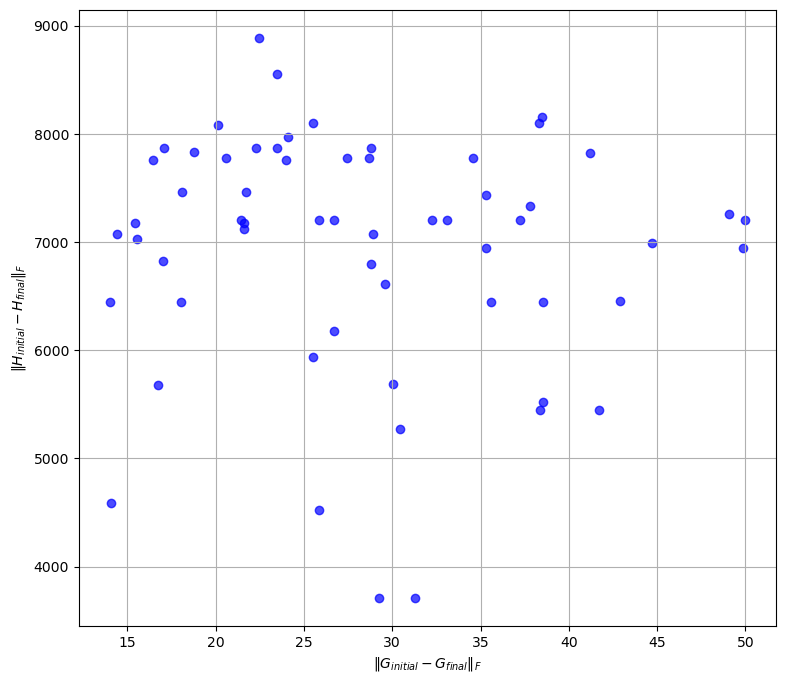

In [5]:
def plot_results(results):
    
    gram_norms = results['gram_norm']
    hamiltonian_norms = results['hamiltonian_norm']
    
    plt.figure(figsize=(9, 8))
    
    plt.scatter(gram_norms, hamiltonian_norms, color='blue', label='Low', alpha=0.7)
    
    plt.xlabel('$\| G_{initial}-G_{final} \|_{F}$')
    plt.ylabel('$\| H_{initial}-H_{final} \|_{F}$')
    plt.grid(True)
    
    plt.show()

plot_results(all_results)